# Machine Unlearning Using Influence Functions - CIFAR-10 Dataset


## Step 1: Setup and Load Data

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB channels
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split train dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Define a CNN Model

In [5]:
# Step 2: Define a Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Step 3: Train the Model

In [6]:
#Step 3: Train the Model
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer)

Epoch [1/5], Loss: 1.6114
Epoch [2/5], Loss: 1.2795
Epoch [3/5], Loss: 1.1337
Epoch [4/5], Loss: 1.0345
Epoch [5/5], Loss: 0.9627


## Step 4: Calculate Influence Functions for Sample Instances

In [7]:
# Step 4: Calculate Influence Scores
def calculate_influence(model, train_loader, sample_size=100):
    model.eval()
    sample_indices = np.random.choice(len(train_loader.dataset), sample_size, replace=False)
    influence_scores = []

    for idx in sample_indices:
        instance, label = train_loader.dataset[idx]
        instance = instance.unsqueeze(0).requires_grad_()  # Add batch dimension and set requires_grad=True
        label = torch.tensor([label])

        # Forward pass
        output = model(instance)
        loss = criterion(output, label)

        # Backward pass: Compute gradients
        grads = torch.autograd.grad(
            loss,
            model.parameters(),
            retain_graph=False,
            create_graph=False,
            allow_unused=True
        )
        
        # Calculate influence as the sum of gradient norms
        influence = sum(grad.norm().item() for grad in grads if grad is not None)
        influence_scores.append((idx, influence))

    # Sort influence scores by magnitude
    influence_scores.sort(key=lambda x: abs(x[1]), reverse=True)
    return influence_scores


sample_influences = calculate_influence(model, train_loader, sample_size=100)

## Batch Unlearning

In [8]:
# Step 5: Batch Unlearning
def unlearn_data(train_dataset, indices_to_remove):
    remaining_indices = list(set(range(len(train_dataset))) - set(indices_to_remove))
    unlearned_dataset = Subset(train_dataset, remaining_indices)
    unlearned_loader = DataLoader(unlearned_dataset, batch_size=64, shuffle=True)
    return unlearned_loader

indices_to_remove = [idx for idx, _ in sample_influences[:10]]
unlearned_train_loader = unlearn_data(train_dataset, indices_to_remove)

# Ensure removed indices are correct
assert len(set(indices_to_remove)) == len(indices_to_remove), "Duplicate indices detected!"
print(f"Removed indices: {indices_to_remove}")

# Retrain the Model After Unlearning
model_unlearned = SimpleCNN()
optimizer_unlearned = optim.Adam(model_unlearned.parameters(), lr=0.001)
train_model(model_unlearned, unlearned_train_loader, criterion, optimizer_unlearned)

Removed indices: [2326, 5483, 19445, 34226, 38150, 32362, 29949, 1443, 6923, 1139]
Epoch [1/5], Loss: 1.5640
Epoch [2/5], Loss: 1.2428
Epoch [3/5], Loss: 1.1034
Epoch [4/5], Loss: 1.0094
Epoch [5/5], Loss: 0.9441


## Step 6: Evaluate Models

In [9]:
# Step 6: Evaluate Models
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    return accuracy, precision, recall, f1

original_metrics = evaluate_model(model, val_loader)
unlearned_metrics = evaluate_model(model_unlearned, val_loader)

Accuracy: 0.6839, Precision: 0.6872, Recall: 0.6839, F1 Score: 0.6837
Accuracy: 0.6835, Precision: 0.6910, Recall: 0.6835, F1 Score: 0.6835


## Step 7: Visualization

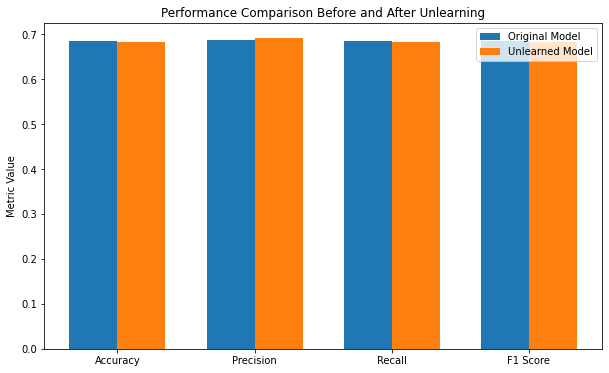

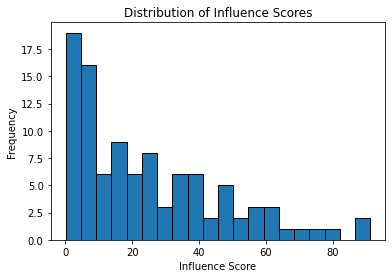

In [10]:
# Step 7: Visualization
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
original_values = original_metrics
unlearned_values = unlearned_metrics

# Plot Performance Comparison
plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.35
plt.bar(x - width/2, original_values, width, label='Original Model')
plt.bar(x + width/2, unlearned_values, width, label='Unlearned Model')
plt.ylabel("Metric Value")
plt.title("Performance Comparison Before and After Unlearning")
plt.xticks(x, metrics)
plt.legend()
plt.show()

# Plot Influence Score Distribution
influences = [score for _, score in sample_influences]
plt.hist(influences, bins=20, edgecolor='black')
plt.xlabel("Influence Score")
plt.ylabel("Frequency")
plt.title("Distribution of Influence Scores")
plt.show()